# Data Acquisition

In [3]:
import os
import urllib
import zipfile
import polars as pl
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
zip_target_folder = "energy-prediction"
!mkdir -p $zip_target_folder

In [5]:
zip_filepath = "energy-prediction.zip"

url_path = "https://archive.ics.uci.edu/static/public/994/micro+gas+turbine+electrical+energy+prediction.zip"
urllib.request.urlretrieve(url_path, zip_filepath)

with zipfile.ZipFile(zip_filepath, "r") as zip_ref:
    zip_ref.extractall(zip_target_folder)

In [6]:
!ls $zip_target_folder

test.zip  train.zip


In [7]:
dataset_part_names = ["train", "test"]

for part_name in dataset_part_names:
    part_target_folder = f"{zip_target_folder}/{part_name}"
    part_zip_path = f"{part_target_folder}.zip"

    with zipfile.ZipFile(part_zip_path, "r") as zip_ref:
        zip_ref.extractall(part_target_folder)

In [8]:
!ls $zip_target_folder

test  test.zip	train  train.zip


In [9]:
!ls -R $zip_target_folder/

energy-prediction/:
test  test.zip	train  train.zip

energy-prediction/test:
test

energy-prediction/test/test:
ex_22.csv  ex_4.csv

energy-prediction/train:
train

energy-prediction/train/train:
ex_1.csv  ex_20.csv  ex_21.csv	ex_23.csv  ex_24.csv  ex_9.csv


In [10]:
!wc -l energy-prediction/train/train/*

   9921 energy-prediction/train/train/ex_1.csv
   6496 energy-prediction/train/train/ex_20.csv
   6496 energy-prediction/train/train/ex_21.csv
   9189 energy-prediction/train/train/ex_23.csv
   9024 energy-prediction/train/train/ex_24.csv
  11820 energy-prediction/train/train/ex_9.csv
  52946 total


In [11]:
train_data_folderpath = f"{zip_target_folder}/train/train/"
test_data_folderpath = f"{zip_target_folder}/test/test/"

In [14]:
reader_properties = {
    # "separator": ";",
    # "decimal_comma": True,
    # "infer_schema_length": 10000
    "infer_schema": False
}

downscaling_frequency = "15i"

def load_experiment_df(experiment_file_path):
    experiment_df = pl.read_csv(experiment_file_path, **reader_properties).with_columns(
        pl.col("time").str.to_decimal().cast(pl.Int64),
        pl.col("input_voltage").str.to_decimal().cast(pl.Float64),
        pl.col("el_power").str.to_decimal().cast(pl.Float64)
    )

    experiment_df = experiment_df.group_by_dynamic("time", every=downscaling_frequency).agg(
        pl.mean("input_voltage"),
        pl.col("el_power").sum(),
    )

    return experiment_df

In [42]:
def load_experiment_df_from_folder(folder_path):
    df = None

    for experiment_file_name in os.listdir(folder_path):
        experiment_file_path = f"{folder_path}/{experiment_file_name}"

        experiment_df = load_experiment_df(experiment_file_path)
        if df is None:
            df = experiment_df
        else:
            df = df.vstack(experiment_df)
    return df

In [43]:
df = load_experiment_df_from_folder(train_data_folderpath)

print("Dataset size:", len(df))

df.head()

Dataset size: 3708


time,input_voltage,el_power
i64,f64,f64
840,3.0,9089.797969
855,3.0,17004.530009
870,3.0,16086.932648
885,3.0,17133.911283
900,3.0,17126.525165


# Data Preprocessing & Representation

In [35]:
df = df.drop_nulls()

df.shape

(3708, 3)

In [36]:
scaler = MinMaxScaler()

scaled_el_power = scaler.fit_transform(df["el_power"].to_numpy().reshape(-1, 1)).flatten()

data = df.with_columns(
    el_power=scaled_el_power
)
data.head()

time,input_voltage,el_power
i64,f64,f64
840,3.0,0.098708
855,3.0,0.27003
870,3.0,0.250168
885,3.0,0.27283
900,3.0,0.27267


In [37]:
def create_forecasting_sets(data: pl.DataFrame, target_name: str, exog: list[str], context_window_size: int, forecast_horizon: int):
    data_size = len(data)
    unit_window_size = context_window_size + forecast_horizon
    features_cols_names = exog + [target_name]

    x, y = [], []

    for i in range(data_size - unit_window_size + 1):
        forecast_start_idx = i + context_window_size
        forecast_stop_idx = forecast_start_idx + forecast_horizon

        seq_prev_data = data[i:forecast_start_idx, target_name].to_list()
        exog_data = list(data[forecast_start_idx, exog].row(0))
        x.append(seq_prev_data + exog_data)

        prediction = data[forecast_start_idx:forecast_stop_idx, target_name]
        y.append(prediction)

    return (np.array(x), np.array(y))

In [38]:
context_window_size = 5
forecast_horizon = 1

In [ ]:
def build_dataset_from_experiment(experiment_filepath):
    df = load_experiment_df(experiment_filepath)
    ret

In [39]:
X_train, y_train = create_forecasting_sets(data, "el_power", ["input_voltage"], context_window_size, forecast_horizon)

X_train.shape, y_train.shape

((3703, 6), (3703, 1))

In [40]:
X_train[:5]

array([[0.09870785, 0.27002977, 0.2501675 , 0.27283036, 0.27267048,
        3.        ],
       [0.27002977, 0.2501675 , 0.27283036, 0.27267048, 0.27731715,
        3.        ],
       [0.2501675 , 0.27283036, 0.27267048, 0.27731715, 0.27309301,
        3.        ],
       [0.27283036, 0.27267048, 0.27731715, 0.27309301, 0.25219194,
        3.        ],
       [0.27267048, 0.27731715, 0.27309301, 0.25219194, 0.27785368,
        3.        ]])

In [41]:
y_train[:5]

array([[0.27731715],
       [0.27309301],
       [0.25219194],
       [0.27785368],
       [0.27271541]])

In [71]:
test_experiment_file_path = f"{test_data_folderpath}/ex_22.csv"
test_df = load_experiment_df(test_experiment_file_path)

scaled_test_data = test_df.with_columns(
    el_power=scaler.transform(test_df["el_power"].to_numpy().reshape(-1, 1)).flatten()
)

X_test, y_test = create_forecasting_sets(scaled_test_data, "el_power", ["input_voltage"], context_window_size, forecast_horizon)

X_test.shape, y_test.shape

((633, 6), (633, 1))

# Modelization

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM

In [48]:
forecast_horizon = 1
lstm_n_units = 64

In [49]:
model = Sequential([
    Input((context_window_size, 1)),
    LSTM(lstm_n_units),
    Dense(forecast_horizon)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

fitting_batch_size = 32
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=fitting_batch_size)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0112 - mae: 0.0715 - val_loss: 6.0770e-04 - val_mae: 0.0103
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5865e-04 - mae: 0.0218 - val_loss: 5.1861e-04 - val_mae: 0.0054
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0325e-04 - mae: 0.0189 - val_loss: 8.2610e-04 - val_mae: 0.0184
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7892e-04 - mae: 0.0191 - val_loss: 5.1793e-04 - val_mae: 0.0054
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7815e-04 - mae: 0.0197 - val_loss: 5.3431e-04 - val_mae: 0.0067
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.6351e-04 - mae: 0.0194 - val_loss: 5.1760e-04 - val_mae: 0.0048
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1860e-04 - mae: 0.0200 - val_loss: 5.6785e-04 - val_mae: 0.0095
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3901e-04 - mae: 0.0192 - val_loss: 6.4742e-04 - val_mae: 0.0

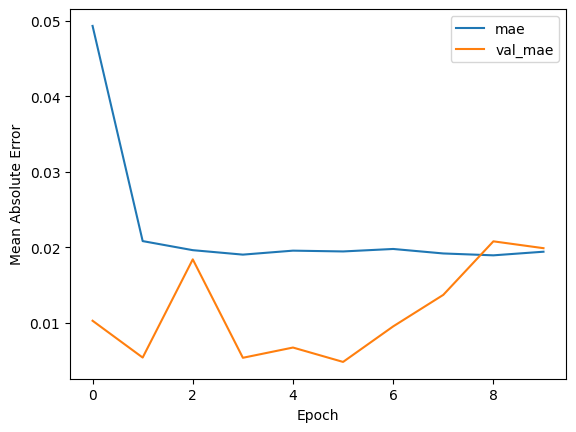

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.legend(["mae", "val_mae"])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.show()

# Evaluation

In [52]:
loss, mae = model.evaluate(X_test, y_test)

print("Evaluation Loss:", loss)
print("Evaluation MAE:", mae)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0256
Evaluation Loss: 0.001674453727900982
Evaluation MAE: 0.027522193267941475


In [53]:
y_pred = model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [54]:
from sklearn.metrics import r2_score

score = r2_score(y_test, y_pred)
print("R2 Score:", score)

R2 Score: 0.9693373873239322


(1287, 1287)


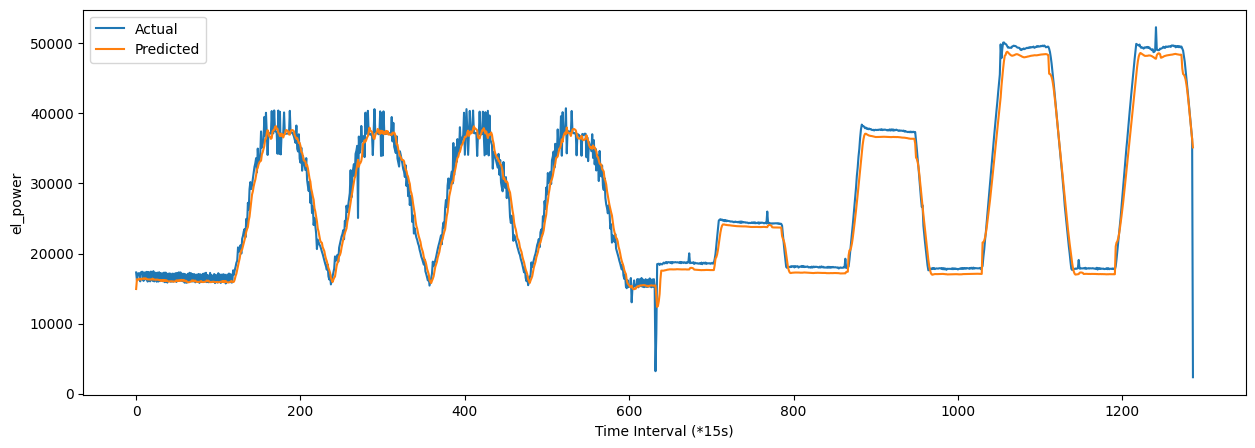

In [55]:
y_pred_inv = scaler.inverse_transform(y_pred).flatten()
y_test_inv = scaler.inverse_transform(y_test).flatten()

print((len(y_pred_inv), len(y_test_inv)))

plt.figure(figsize=(15,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.xlabel("Time Interval (*15s)")
plt.ylabel("el_power")
plt.legend()
plt.show()

# Model Backup

In [56]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [57]:
backup_folder_path = "/gdrive/MyDrive/ESTIAM/E5/AI-ML-Model-Design/TimeSeries-Forecasting/backup"

In [58]:
!mkdir -p "$backup_folder_path"

In [59]:
scaler_file_path = f"{backup_folder_path}/scaler.joblib"
model_file_path = f"{backup_folder_path}/model.keras"

In [60]:
import joblib

joblib.dump(scaler, scaler_file_path)
model.save(model_file_path)

In [61]:
!ls "$backup_folder_path"

model.keras  scaler.joblib


# Model Loading & Manual Testing

## Loading

In [62]:
from tensorflow import keras

loaded_scaler = joblib.load(scaler_file_path)
loaded_model = keras.models.load_model(model_file_path)

In [63]:
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,885 (198.77 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,924 (132.52 KB)

## Testing

## From file

Setup test data

In [93]:
test_experiment_file_path = f"{test_data_folderpath}/ex_4.csv"
test_df = load_experiment_df(test_experiment_file_path)

scaled_test_data = test_df.with_columns(
    el_power=scaler.transform(test_df["el_power"].to_numpy().reshape(-1, 1)).flatten()
)

input, output = create_forecasting_sets(scaled_test_data, "el_power", ["input_voltage"], context_window_size, forecast_horizon)

input.shape, output.shape

((649, 6), (649, 1))

Predict with model

In [94]:
y_pred = loaded_model.predict(input)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Display predicted value

In [95]:
y_pred[:5]

array([[0.25536555],
       [0.28204504],
       [0.28203   ],
       [0.2818088 ],
       [0.28189036]], dtype=float32)

Display unscaled prediction

In [96]:
predicted = scaler.inverse_transform(y_pred).flatten()
predicted[:5].tolist()

[16327.072265625,
 17559.611328125,
 17558.916015625,
 17548.697265625,
 17552.46484375]

(649, 649)


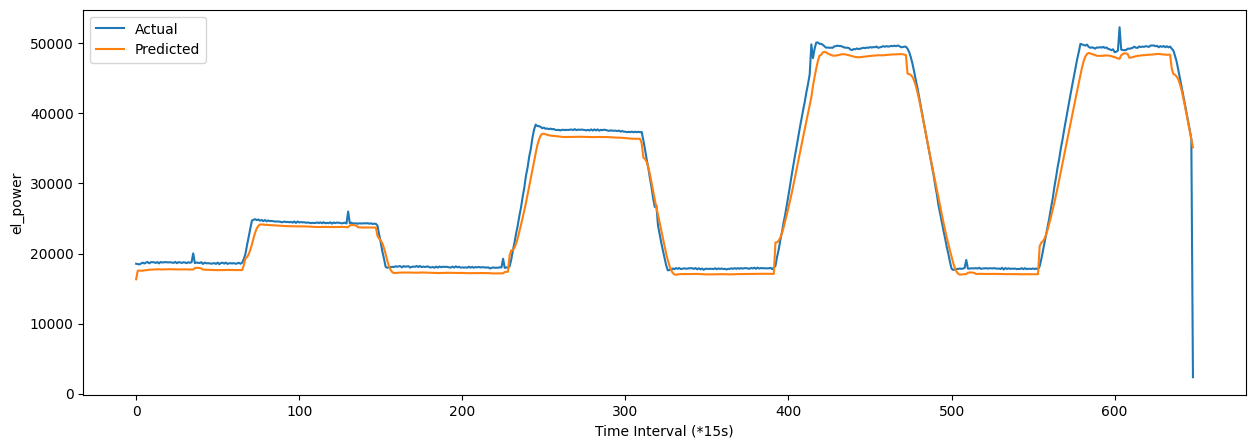

In [97]:
expected = scaler.inverse_transform(output).flatten()

print((len(predicted), len(expected)))

plt.figure(figsize=(15,5))
plt.plot(expected, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Time Interval (*15s)")
plt.ylabel("el_power")
plt.legend()
plt.show()

## Custom data

In [99]:
sample_data = pl.DataFrame(
    [
        (18500, 3),
        (15600, 3),
        (17000, 3),
        (19850, 3),
        (18750, 3),
        (15620, 3),
        (17050, 3),
        (16920, 3),
        (17350, 3),
        (20450, 5),
        (19320, 5),
        (19950, 5),
    ],
    schema={
        "el_power": pl.Float64,
        "input_voltage": pl.Float64,
    },
    orient="row",
)

scaled_sample_data = sample_data.with_columns(
    el_power=loaded_scaler.transform(sample_data["el_power"].to_numpy().reshape(-1, 1)).flatten()
)

print("Dataset size:", len(scaled_sample_data))

(input, output) = create_forecasting_sets(scaled_sample_data, "el_power", ["input_voltage"], context_window_size, forecast_horizon)

y_pred = loaded_model.predict(input)

Dataset size: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


(7, 7)


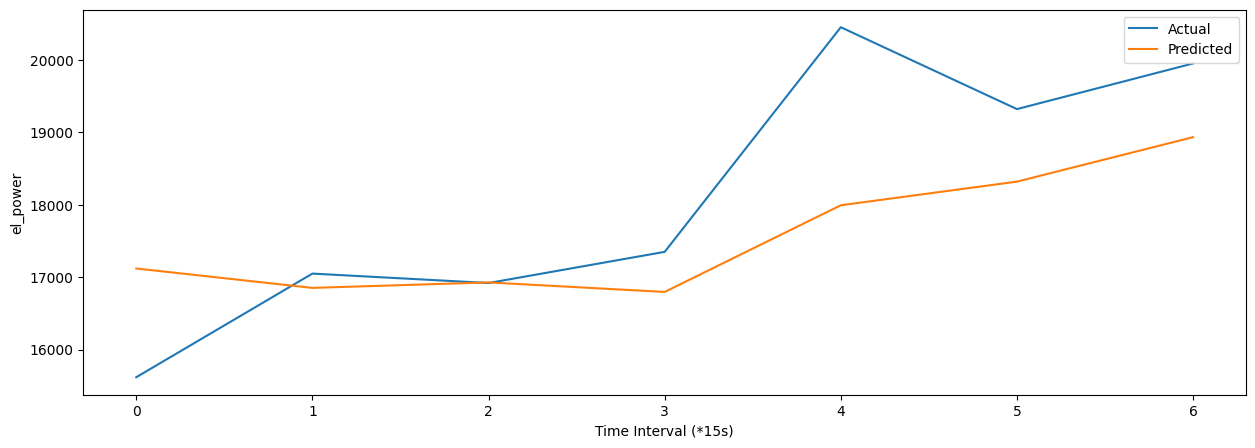

In [100]:
predicted = scaler.inverse_transform(y_pred).flatten()

expected = scaler.inverse_transform(output).flatten()

print((len(predicted), len(expected)))

plt.figure(figsize=(15,5))
plt.plot(expected, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Time Interval (*15s)")
plt.ylabel("el_power")
plt.legend()
plt.show()